In [4]:
# Imports and Setup
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize
from datasketch import MinHashLSH, MinHash
import re
from collections import defaultdict
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Download required NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /home/ankit21311/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ankit21311/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/ankit21311/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [5]:
# Load training data
with open('ids.txt', 'r') as f:
    ids = [line.strip() for line in f]

with open('texts.txt', 'r') as f:
    texts = [line.strip() for line in f]

In [8]:
class TextSimilarityLSH:
    def __init__(self, num_perm=128, threshold=0.5):
        self.num_perm = num_perm
        self.threshold = threshold
        self.lsh = MinHashLSH(threshold=threshold, num_perm=num_perm)
        self.minhashes = {}
        self.vectorizer = None
        self.lemmatizer = WordNetLemmatizer()
        self.stop_words = set(stopwords.words('english'))
        
    def preprocess_text(self, text):
        # Convert to lowercase
        text = text.lower()
        # Remove special characters and digits
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        # Tokenize
        tokens = word_tokenize(text)
        # Remove stopwords and lemmatize
        tokens = [self.lemmatizer.lemmatize(token) for token in tokens 
                 if token not in self.stop_words]
        return ' '.join(tokens)
    
    def get_shingles(self, text, k=3):
        return [text[i:i+k] for i in range(len(text)-k+1)]
    
    def create_minhash(self, text):
        m = MinHash(num_perm=self.num_perm)
        for shingle in self.get_shingles(text):
            m.update(shingle.encode('utf-8'))
        return m
    def fit(self, ids, texts):
        processed_texts = [self.preprocess_text(text) for text in texts]
        
        self.vectorizer = TfidfVectorizer(
            min_df=2,
            max_df=0.95,
            ngram_range=(1, 2)
        )
        self.vectorizer.fit(processed_texts)
        
        for id_, text in zip(ids, processed_texts):
            minhash = self.create_minhash(text)
            self.minhashes[id_] = minhash
            self.lsh.insert(id_, minhash)
    
    def query(self, query_id, top_k=5):
        if query_id not in self.minhashes:
            return []
        
        candidates = self.lsh.query(self.minhashes[query_id])
        
        candidates = [c for c in candidates if c != query_id]
        
        if len(candidates) < top_k:
            return candidates
        
        query_hash = self.minhashes[query_id]
        similarities = []
        for candidate_id in candidates:
            candidate_hash = self.minhashes[candidate_id]
            similarity = query_hash.jaccard(candidate_hash)
            similarities.append((candidate_id, similarity))
        
        similarities.sort(key=lambda x: x[1], reverse=True)
        return [x[0] for x in similarities[:top_k]]
    def evaluate(self, ground_truth_file):
        with open(ground_truth_file, 'r') as f:
            ground_truth = json.load(f)
            
        intersection_scores = []
        for query_id, true_similar in ground_truth.items():
            predicted_similar = self.query(query_id)
            intersection = set(predicted_similar) & set(true_similar)
            intersection_scores.append(len(intersection))
            
        return np.array(intersection_scores)
    
    def plot_statistics(self, scores):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Histogram
        sns.histplot(scores, bins=6, ax=ax1)
        ax1.set_title('Distribution of Intersection Scores')
        ax1.set_xlabel('Number of Correct Predictions')
        ax1.set_ylabel('Count')
        
        # Box plot
        sns.boxplot(x=scores, ax=ax2)
        ax2.set_title('Box Plot of Intersection Scores')
        ax2.set_xlabel('Intersection Score')
        
        plt.tight_layout()
        plt.show()
        
        # Print descriptive statistics
        print("\nDescriptive Statistics:")
        print(pd.Series(scores).describe())
    

model = TextSimilarityLSH(num_perm=128, threshold=0.5)
model.fit(ids, texts)

In [9]:
scores = model.evaluate('items.json')


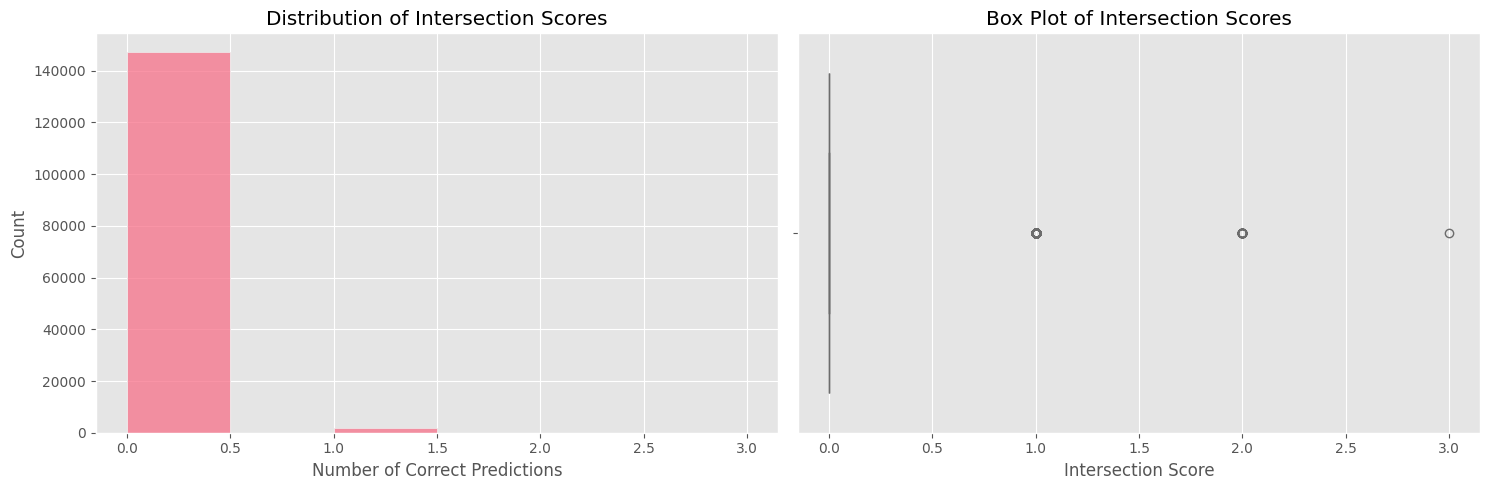


Descriptive Statistics:
count    148928.000000
mean          0.012516
std           0.113149
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           3.000000
dtype: float64


In [12]:
model.plot_statistics(scores)
